In [16]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform




Cursos = pd.read_excel('Cursos.xlsx')
Actual = pd.read_csv('MES ACTUAL.csv', encoding='latin1', sep=';')
Antiguo = pd.read_csv('VENTAS ANTIGUAS.csv', encoding='latin1', sep=';')


## Preprocesamiento datos de ventas

In [17]:
#Nos aseguramos de que las fechas estén en el formato correcto
meses = {
    'Enero': '01', 'Febrero': '02', 'Marzo': '03', 'Abril': '04',
    'Mayo': '05', 'Junio': '06', 'Julio': '07', 'Agosto': '08',
    'Septiembre': '09', 'Octubre': '10', 'Noviembre': '11', 'Diciembre': '12'
}

Locales = Actual[['Código SAP POS', 'Cadena', 'Local']].drop_duplicates() #Guardamos los locales que están en el mes actual
Locales = Locales[Locales['Código SAP POS'] != 'No Definido']


for df in [Actual, Antiguo]:
    #Cambiar el formato de las columnas de precios para que sean numéricas (quitamos los puntos de miles y cambiamos la coma decimal por punto)
    df['Valores PVP c/IVA'] = (
        df['Valores PVP c/IVA']
        .astype(str)
        .str.replace('.', '', regex=False)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )

    #Asegurar que las fechas sean datetime
    df['Fechas'] = df['Fechas'].replace(meses, regex=True)
    df['Fechas'] = pd.to_datetime(df['Fechas'], format='%m %Y')
    df["Año"] = df["Fechas"].dt.year
    df["Mes"] = df["Fechas"].dt.month


    # Filtrar columnas y eliminar filas con "No Definido"
    df.drop(df[df["Código SAP POS"] == "No Definido"].index, inplace=True)



Actual = Actual[['Fechas', 'Código SAP POS','Valores PVP c/IVA', 'Año', 'Mes']]
Antiguo = Antiguo[['Fechas', 'Código SAP POS','Valores PVP c/IVA', 'Año', 'Mes']]


#Mantenemos solo los locales que están en la lista de Locales del último mes
Antiguo = Antiguo[Antiguo["Código SAP POS"].isin(Locales["Código SAP POS"])]



In [18]:


# Detectar mes y año actual en Actual
anio_actual = Actual["Año"].max()
mes_actual = Actual[Actual["Año"] == anio_actual]["Mes"].max()

#Definimos el mes en el año actual, y el mes en el año pasado
ventas_actual = Actual[(Actual["Año"] == anio_actual) & (Actual["Mes"] == mes_actual)]
ventas_pasado = Antiguo[(Antiguo["Año"] == anio_actual - 1) & (Antiguo["Mes"] == mes_actual)]

# Agrupar ventas por local para el mes actual y el mes del año pasado
agg_actual = ventas_actual.groupby("Código SAP POS")["Valores PVP c/IVA"].sum().rename("Venta_Actual")
agg_pasado = ventas_pasado.groupby("Código SAP POS")["Valores PVP c/IVA"].sum().rename("Venta_Pasado")



# Unir y calcular cambio absoluto y porcentual
df_merge = pd.merge(agg_actual, agg_pasado, on="Código SAP POS", how="left").fillna(0)

df_merge = df_merge[df_merge["Venta_Pasado"] != 0]
df_merge = df_merge[df_merge["Venta_Actual"] != 0]

df_merge["Cambio $"] = df_merge["Venta_Actual"] - df_merge["Venta_Pasado"]
df_merge["Cambio %"] = np.where(df_merge["Venta_Pasado"] != 0,
                                df_merge["Cambio $"] / df_merge["Venta_Pasado"] * 100,
                                np.nan)


df_merge.reset_index(inplace=True)
df_merge.rename(columns={"Código SAP POS": "Door Code"}, inplace=True)


# Agregar columna de fecha del mes analizado
fecha_referencia = datetime(anio_actual, mes_actual, 1)
df_merge["Fecha"] = fecha_referencia


## Preprocesamiento datos de Cursos

In [19]:
#Filtramos solo los cursos de fuerza de venta externa
Cursos = Cursos[(Cursos['Country'] == 'Chile')]
Cursos = Cursos[(Cursos['Employee Type'] == "8") | (Cursos['Employee Type'] == 8)]
Cursos["Door Code"] = Cursos["Door Code"].astype(str).str.strip()

#Quitamos los cursos que no tienen fecha de completación, tiempo invertido o o código de puerta
Cursos = Cursos.dropna(subset=['Completion date'])
Cursos = Cursos[Cursos["Door Code"]!="-"]
Cursos = Cursos.dropna(subset=['Time (sec)'])       
Cursos = Cursos[['Door Code','Points', 'Time (sec)', 'Completion date']]


#Aseguramos que las fechas sean datetime
Cursos['Completion date'] = pd.to_datetime(
    Cursos['Completion date'].astype(float).astype(int).astype(str),
    format='%Y%m%d'
)

# Extraer año y mes
Cursos["Año"] = Cursos["Completion date"].dt.year
Cursos["Mes"] = Cursos["Completion date"].dt.month


# Agrupamos por local, año y mes
Cursos_agrupado = Cursos.groupby(["Door Code", "Año", "Mes"]).agg({
    "Completion date": "count",     # cantidad de cursos completados
    "Points": "sum",                # suma de puntos
    "Time (sec)": "sum"             # suma de tiempo
}).reset_index()

# Renombrar la columna de cantidad de cursos
Cursos_agrupado.rename(columns={"Completion date": "Cantidad de Cursos"}, inplace=True)



Depreciación de los cursos completados más antigüamente

In [20]:
# Calcular antigüedad en meses respecto al mes actual
Cursos_agrupado["Meses_atras"] = (anio_actual - Cursos_agrupado["Año"]) * 12 + (mes_actual - Cursos_agrupado["Mes"])

display(Cursos_agrupado)

# Asignar peso depreciado
#Se deprecia linealmente, y al pasar los 12 meses, el peso es 0.1

def peso_depreciado(edad):
    if edad < 0:
        return 0
    elif edad >= 12:
        return 0.1
    else:
        return 1 - (3/40) * edad


Cursos_agrupado["Peso"] = Cursos_agrupado["Meses_atras"].apply(peso_depreciado)

# Calcular valores ponderados directamente en el mismo DataFrame
Cursos_agrupado["Cursos ponderados"] = Cursos_agrupado["Cantidad de Cursos"] * Cursos_agrupado["Peso"]
Cursos_agrupado["Puntos ponderados"] = Cursos_agrupado["Points"] * Cursos_agrupado["Peso"]
Cursos_agrupado["Tiempo ponderado"] = Cursos_agrupado["Time (sec)"] * Cursos_agrupado["Peso"]
Cursos_agrupado[Cursos_agrupado["Mes"] == mes_actual]["Cantidad de Cursos"].sum()

,Door Code,Año,Mes,Cantidad de Cursos,Points,Time (sec),Meses_atras
0,3394284,2025,5,10,1350.0,3530.0,1
1,3394286,2025,5,19,1895.0,9762.0,1
2,3394286,2025,6,3,210.0,765.0,0
3,3394287,2025,5,4,483.0,3101.0,1
4,3394306,2025,5,18,2459.0,11193.0,1
...,...,...,...,...,...,...,...
63,3436274,2025,5,38,8691.0,15647.0,1
64,3436274,2025,6,3,447.0,487.0,0
65,3436280,2025,5,21,3400.0,15194.0,1
66,3436280,2025,6,1,11.0,28.0,0


193

In [21]:
df_var = Cursos_agrupado.groupby("Door Code")[["Cursos ponderados", "Puntos ponderados", "Tiempo ponderado"]].sum().reset_index()  #Agrupamos por local y sumamos los valores ponderados
df_var = pd.merge(df_var, df_merge, on="Door Code", how="inner")  #Unimos los datos de ventas con los de cursos


df_var = df_var[['Door Code','Puntos ponderados', 'Tiempo ponderado', 'Cursos ponderados', 'Cambio %']]


## Análisis Exploratorio

In [22]:
df_var.describe()

,Puntos ponderados,Tiempo ponderado,Cursos ponderados,Cambio %
count,51.000000,51.000000,51.000000,51.000000
mean,1643.139216,3928.580882,12.183824,-6.740285
std,1890.184025,4362.478063,11.413334,26.344567
min,9.250000,22.200000,0.925000,-51.111145
25%,354.275000,556.400000,2.775000,-20.124521
50%,771.175000,1971.175000,7.400000,-8.540045
75%,2544.587500,5481.175000,20.825000,-2.014979
max,8486.175000,15913.000000,52.000000,110.485110


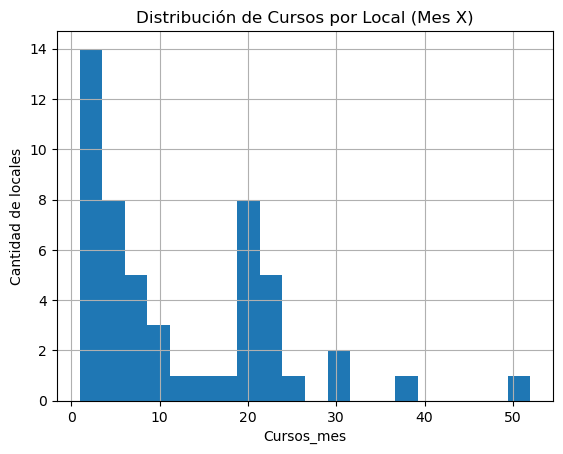

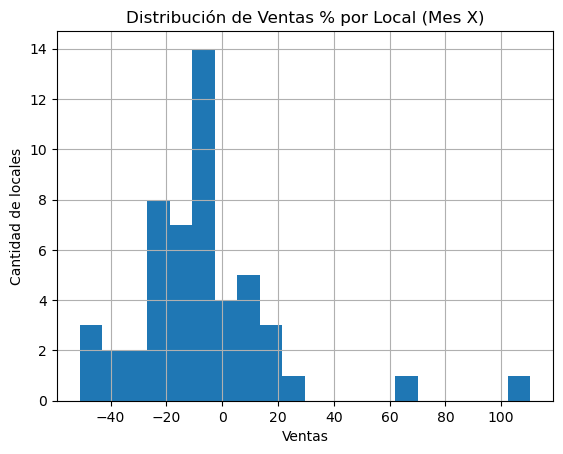

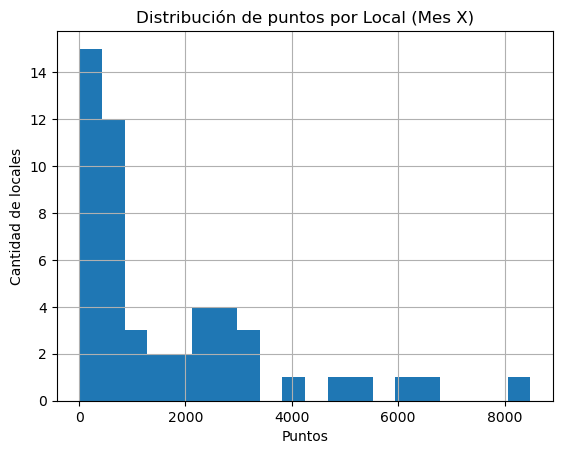

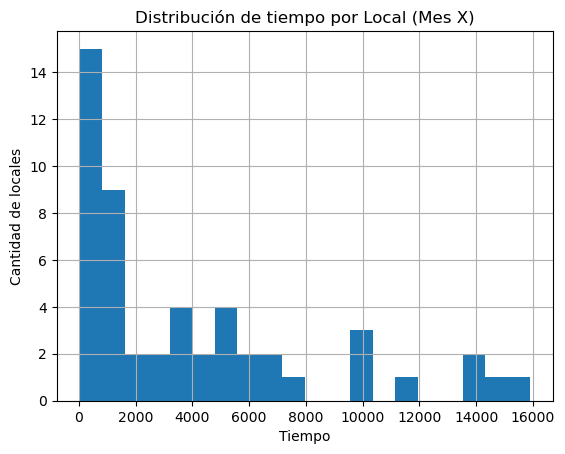

In [23]:
df_var["Cursos ponderados"].hist(bins=20)
plt.title("Distribución de Cursos por Local (Mes X)")
plt.xlabel("Cursos_mes")
plt.ylabel("Cantidad de locales")
plt.show()

df_var["Cambio %"].hist(bins=20)
plt.title("Distribución de Ventas % por Local (Mes X)")
plt.xlabel("Ventas")
plt.ylabel("Cantidad de locales")
plt.show()

df_var["Puntos ponderados"].hist(bins=20)
plt.title("Distribución de puntos por Local (Mes X)")
plt.xlabel("Puntos")
plt.ylabel("Cantidad de locales")
plt.show()

df_var["Tiempo ponderado"].hist(bins=20)
plt.title("Distribución de tiempo por Local (Mes X)")
plt.xlabel("Tiempo")
plt.ylabel("Cantidad de locales")
plt.show()

In [24]:

print(df_var[["Cursos ponderados", "Cambio %"]].corr())

print(df_var[["Puntos ponderados", "Cambio %"]].corr())

print(df_var[["Tiempo ponderado", "Cambio %"]].corr())


                   Cursos ponderados  Cambio %
Cursos ponderados           1.000000  0.187304
Cambio %                    0.187304  1.000000
                   Puntos ponderados  Cambio %
Puntos ponderados           1.000000  0.330567
Cambio %                    0.330567  1.000000
                  Tiempo ponderado  Cambio %
Tiempo ponderado          1.000000  0.186481
Cambio %                  0.186481  1.000000


<Axes: >

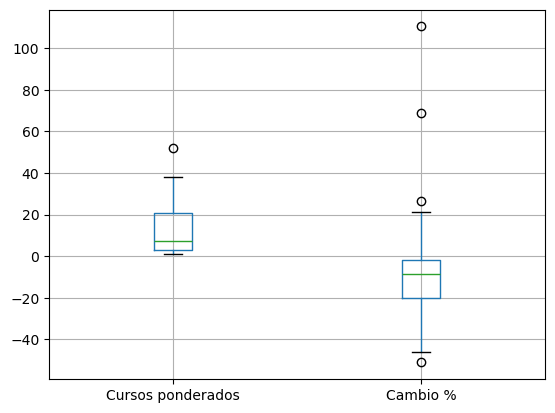

In [25]:
df_var.boxplot(column=["Cursos ponderados", "Cambio %"])

<Axes: >

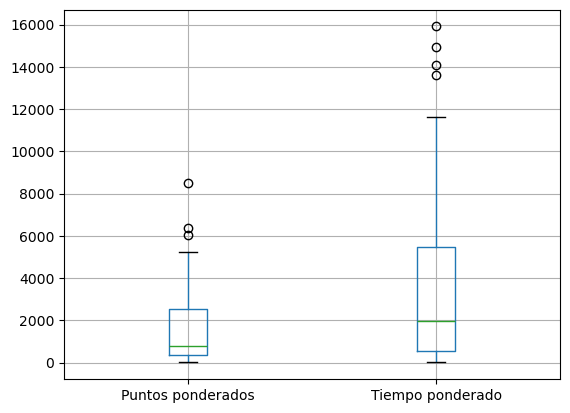

In [26]:
df_var.boxplot(column=["Puntos ponderados", "Tiempo ponderado"])

## Modelo no supervisado

In [27]:

# Normalizamos los datos

features = ["Cursos ponderados", "Cambio %", "Puntos ponderados","Tiempo ponderado"]

X = X = df_var[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Clusters: 2, Silhouette Score: 0.5225
Clusters: 3, Silhouette Score: 0.4204
Clusters: 4, Silhouette Score: 0.3980
Clusters: 5, Silhouette Score: 0.3092


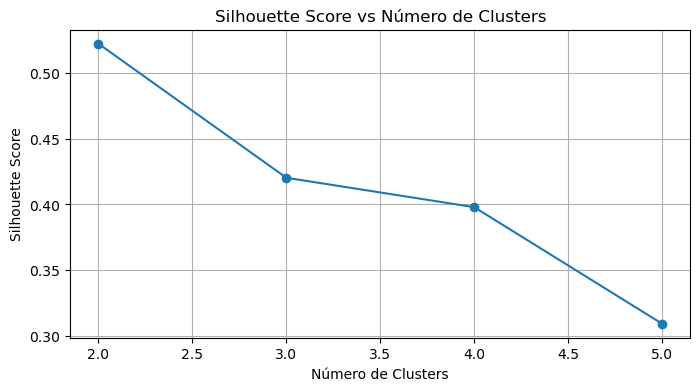


Clusters óptimos según Silhouette Score: 2


In [28]:


# Quitamos los outliers usando Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(X_scaled)  # 1 = normal, -1 = outlier

X_scaled = X_scaled[outliers == 1]
df_var = df_var[outliers == 1].reset_index(drop=True)

# Definimos el rango de clusters a probar
range_n_clusters = range(2, 6)

# Calcular Silhouette Score para cada número de clusters
silhouette_scores = []

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Graficar
for i, score in enumerate(silhouette_scores, start=2):
    print(f"Clusters: {i}, Silhouette Score: {score:.4f}")
plt.figure(figsize=(8, 4))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Elegir automáticamente el número óptimo de clusters
optimal_k = np.argmax(silhouette_scores) + 2  # +2 porque empezamos en k=2
print(f"\nClusters óptimos según Silhouette Score: {optimal_k}")

# Aplicar K-Means con el número óptimo
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
df_var["Cluster"] = kmeans_final.fit_predict(X_scaled)



In [29]:


# Creamos rango de parámetros a probar para DBSCAN, los parámetros a cambiar son eps y min_samples
eps_values = np.arange(0.5, 1.6, 0.1)         # eps de 0.5 a 1.5 en pasos de 0.1
min_samples_values = range(3, 8)              # min_samples de 3 a 7

results = []

# Hacemos una búsqueda de grilla para encontrar los mejores parámetros combinados
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(X_scaled)

        # Cuántos clusters se crearon (no contamos el ruido)
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

        # Calculamos Silhouette Score solo si hay más de 1 cluster válido
        if n_clusters > 1:
            score = silhouette_score(X_scaled[cluster_labels != -1], cluster_labels[cluster_labels != -1])
        else:
            score = np.nan  # no calcular score si no hay suficientes clusters

        # Calcular % de ruido
        prop_noise = (cluster_labels == -1).mean() * 100

        # Guardar resultado
        results.append({
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "silhouette_score": score,
            "prop_noise": prop_noise
        })


results_df = pd.DataFrame(results)

# Mostramos
print("\nResultados ordenados por Silhouette Score (top 10):")
display(results_df.sort_values(by="silhouette_score", ascending=False).head(10))

# Elegimos la mejor combinación de parámetros (mayor a menor Silhouette Score)
best_params = results_df.sort_values(by="silhouette_score", ascending=False).iloc[0]
best_eps = best_params["eps"]
best_min_samples = int(best_params["min_samples"])

print(f"\n✅ Mejores parámetros encontrados: eps = {best_eps}, min_samples = {best_min_samples}")

# Aplicamos DBSCAN con los mejores parámetros
best_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
cluster_labels = best_dbscan.fit_predict(X_scaled)

df_var["Cluster_DBSCAN"] = cluster_labels

print("Clusters encontrados (DBSCAN):")
print(df_var["Cluster_DBSCAN"].value_counts())


Resultados ordenados por Silhouette Score (top 10):


,eps,min_samples,n_clusters,silhouette_score,prop_noise
7,0.6,5,2,0.627120,39.583333
14,0.7,7,2,0.593041,33.333333
2,0.5,5,3,0.565528,45.833333
1,0.5,4,3,0.565528,45.833333
12,0.7,5,2,0.547896,27.083333
13,0.7,6,2,0.547896,27.083333
18,0.8,6,2,0.542503,22.916667
19,0.8,7,2,0.538363,25.000000
20,0.9,3,2,0.524163,10.416667
15,0.8,3,2,0.524163,10.416667



✅ Mejores parámetros encontrados: eps = 0.6, min_samples = 5
Clusters encontrados (DBSCAN):
Cluster_DBSCAN
 0    23
-1    19
 1     6
Name: count, dtype: int64


## Resumen de los resultados

In [30]:

# Empezamos por K-Means
print("\n Calidad del clustering: K-Means")

# Silhouette Score K-Means
silhouette_kmeans = silhouette_score(X_scaled, df_var["Cluster"])
print(f"Silhouette Score (K-Means): {silhouette_kmeans:.4f}")

# Balance de clusters K-Means
print("\nBalance de clusters (K-Means):")
print(df_var["Cluster"].value_counts())

print("\nProporción de clusters (K-Means):")
print((df_var["Cluster"].value_counts(normalize=True) * 100).round(2).astype(str) + " %")

# Distancias entre clusters K-Means
centroids = kmeans_final.cluster_centers_
inter_cluster_distances = squareform(pdist(centroids))

print("\nDistancias entre clusters (K-Means):")
print(inter_cluster_distances)

print("-" * 50)

#  DBSCAN
print("\nCalidad del clustering: DBSCAN")

# Silhouette Score DBSCAN (solo si hay >1 cluster válido)
n_clusters_dbscan = len(set(df_var["Cluster_DBSCAN"])) - (1 if -1 in df_var["Cluster_DBSCAN"].unique() else 0)

if n_clusters_dbscan > 1:
    silhouette_dbscan = silhouette_score(
        X_scaled[df_var["Cluster_DBSCAN"] != -1], 
        df_var["Cluster_DBSCAN"][df_var["Cluster_DBSCAN"] != -1]
    )
    print(f"Silhouette Score (DBSCAN): {silhouette_dbscan:.4f}")
else:
    print("Silhouette Score (DBSCAN): No se puede calcular (menos de 2 clusters válidos).")

# Balance de clusters DBSCAN (incluye ruido)
print("\nBalance de clusters (DBSCAN):")
print(df_var["Cluster_DBSCAN"].value_counts())

print("\nProporción de clusters (DBSCAN):")
print((df_var["Cluster_DBSCAN"].value_counts(normalize=True) * 100).round(2).astype(str) + " %")

# Proporción de ruido en DBSCAN
prop_noise = (df_var["Cluster_DBSCAN"] == -1).mean() * 100
print(f"\nProporción de ruido (DBSCAN): {prop_noise:.2f} %")



 Calidad del clustering: K-Means
Silhouette Score (K-Means): 0.5225

Balance de clusters (K-Means):
Cluster
0    32
1    16
Name: count, dtype: int64

Proporción de clusters (K-Means):
Cluster
0    66.67 %
1    33.33 %
Name: proportion, dtype: object

Distancias entre clusters (K-Means):
[[0.         2.54462741]
 [2.54462741 0.        ]]
--------------------------------------------------

Calidad del clustering: DBSCAN
Silhouette Score (DBSCAN): 0.6271

Balance de clusters (DBSCAN):
Cluster_DBSCAN
 0    23
-1    19
 1     6
Name: count, dtype: int64

Proporción de clusters (DBSCAN):
Cluster_DBSCAN
 0    47.92 %
-1    39.58 %
 1     12.5 %
Name: proportion, dtype: object

Proporción de ruido (DBSCAN): 39.58 %
